## Equations of motion

Consider particles with mass $m_i$, position $\mathbf x_i(t) \in \mathbb R^3$, and momentum $\mathbf p_i(t) \in \mathbb R^3$, indexed by $i \in \{ 1, \dotsc, n \}$.  Then their equation of motion is the ordinary differential equation

\begin{align}
  \dot{\mathbf x_i} &= \frac{\mathbf p_i}{m_i} \\
  \dot{\mathbf p_i} &= \sum_{j\ne i} \mathbf f_{ij} \\
\end{align}

where

$$ \mathbf f_{ij} = G m_i m_j \frac{\mathbf x_j - \mathbf x_i}{\lVert \mathbf x_j - \mathbf x_i \rVert^3} $$

is the force exerted on particle $i$ by particle $j$, and $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant).

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

G = 6.6743015e-11 # gravitational constant

def force(m, x):
    n = len(x)
    f = np.zeros_like(x)
    i = np.arange(n, dtype=int)
    for jj in range(1, n):
        j = ((i + jj) % n).tolist()
        r = x[j] - x  # Vector from x_i to x_j
        f += (G * m * m[j] / np.linalg.norm(r, axis=1)**3)[:, None] * r
    return f

def init_earth_ball():
    m = np.array([5.9722e24, 1])
    x = np.array([[0, 0],
                  [6.37e6, 0]])
    return m, x
m, x = init_earth_ball()
force(m, x)

array([[ 9.82338804,  0.        ],
       [-9.82338804,  0.        ]])

Compare the magnitude to the acceleration due to gravity on earth ($9.8 m/s^2$) and observe symmetry ([Newton's third law](https://en.wikipedia.org/wiki/Newton's_laws_of_motion)).

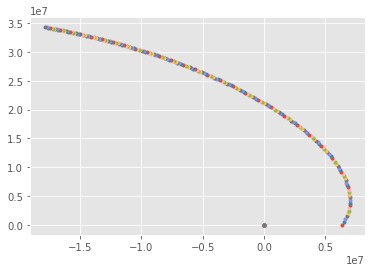

In [120]:
def step(m, x, p, dt):
    x += dt * p / m[:,None]
    p += dt * force(m, x)

m, x = init_earth_ball()
p = np.array([[0, 0],
             [3e3, 10e3]])
for s in range(200):
    plt.plot(x[:,0], x[:,1], '.')
    step(m, x, p, 50)

## Optimizing force evaluation

In [121]:
def render_c(filename):
    from IPython.display import Markdown
    with open(filename) as f:
        contents = f.read()
    return Markdown("```c\n" + contents + "```\n")

render_c('force.c')

```c
#include <math.h>

void force1(int m, const float xmass[], const float x[],
            int n, const float ymass[], const float y[],
            float f[]) {
  for (int i=0; i<m; i++) {
    for (int j=0; j<n; j++) {
      float r[3] = {y[j*3+0] - x[i*3+0],
                    y[j*3+1] - x[i*3+1],
                    y[j*3+2] - x[i*3+2]};
      float r2 = r[0]*r[0] + r[1]*r[1] + r[2]*r[2];
      float Gmm = xmass[i] * ymass[j] / (r2 * sqrt(r2));
      for (int k=0; k<3; k++)
        f[i*3+k] += Gmm * r[k];
    }
  }
}
```


In [116]:
from IPython.display import HTML
HTML(r'''<iframe width="1200px" height="800px" src="https://gcc.godbolt.org/e#g:!((g:!((g:!((h:codeEditor,i:(fontScale:14,j:1,lang:___c,source:'%23include+%3Cmath.h%3E%0A%0Avoid+force1(int+m,+const+float+xmass%5B%5D,+const+float+x%5B%5D,%0A++++++++++++int+n,+const+float+ymass%5B%5D,+const+float+y%5B%5D,%0A++++++++++++float+f%5B%5D)+%7B%0A++for+(int+i%3D0%3B+i%3Cm%3B+i%2B%2B)+%7B%0A++++for+(int+j%3D0%3B+j%3Cn%3B+j%2B%2B)+%7B%0A++++++float+r%5B3%5D+%3D+%7By%5Bj*3%2B0%5D+-+x%5Bi*3%2B0%5D,%0A++++++++++++++++++++y%5Bj*3%2B1%5D+-+x%5Bi*3%2B1%5D,%0A++++++++++++++++++++y%5Bj*3%2B2%5D+-+x%5Bi*3%2B2%5D%7D%3B%0A++++++float+r2+%3D+r%5B0%5D*r%5B0%5D+%2B+r%5B1%5D*r%5B1%5D+%2B+r%5B2%5D*r%5B2%5D%3B%0A++++++float+Gmm+%3D+xmass%5Bi%5D+*+ymass%5Bj%5D+/+(r2+*+sqrt(r2))%3B%0A++++++for+(int+k%3D0%3B+k%3C3%3B+k%2B%2B)%0A++++++++f%5Bi*3%2Bk%5D+%2B%3D+Gmm+*+r%5Bk%5D%3B%0A++++%7D%0A++%7D%0A%7D%0A'),l:'5',n:'0',o:'C+source+%231',t:'0')),k:43.054234062797335,l:'4',m:100,n:'0',o:'',s:0,t:'0'),(g:!((h:compiler,i:(compiler:cg92,filters:(b:'0',binary:'1',commentOnly:'0',demangle:'1',directives:'0',execute:'1',intel:'0',libraryCode:'1',trim:'0'),fontScale:14,lang:___c,libs:!(),options:'-Ofast+-march%3Dskylake-avx512+-fopenmp-simd',source:1),l:'5',n:'0',o:'x86-64+gcc+9.2+(Editor+%231,+Compiler+%231)+C',t:'0')),k:56.945765937202665,l:'4',m:100,n:'0',o:'',s:0,t:'0')),l:'2',n:'0',o:'',t:'0')),version:4"></iframe>''')

In [122]:
render_c('force2.c')

```c
#include <math.h>

void force2(int m, const float xmass[], const float x[],
            int n, const float ymass[], const float y[],
            float f[]) {
  for (int i=0; i<m; i++) {
    for (int j=0; j<n; j++) {
      float r[3] = {y[0*m+j] - x[0*n+i],
                    y[1*m+j] - x[1*n+i],
                    y[2*m+j] - x[2*n+i]};
      float r2 = r[0]*r[0] + r[1]*r[1] + r[2]*r[2];
      float Gmm = xmass[i] * ymass[j] / (r2 * sqrt(r2));
      for (int k=0; k<3; k++)
        f[k*m+i] += Gmm * r[k];
    }
  }
}
```


In [115]:
HTML(r'''<iframe width="1200px" height="800px" src="https://gcc.godbolt.org/e#g:!((g:!((g:!((h:codeEditor,i:(fontScale:14,j:1,lang:___c,source:'%23include+%3Cmath.h%3E%0A%0Avoid+force2(int+m,+const+float+xmass%5B%5D,+const+float+x%5B%5D,+%0A++++++++++++int+n,+const+float+ymass%5B%5D,+const+float+y%5B%5D,%0A++++++++++++float+f%5B%5D)+%7B%0A++for+(int+i%3D0%3B+i%3Cm%3B+i%2B%2B)+%7B%0A++++for+(int+j%3D0%3B+j%3Cn%3B+j%2B%2B)+%7B%0A++++++float+r%5B3%5D+%3D+%7By%5B0*m%2Bj%5D+-+x%5B0*n%2Bi%5D,%0A++++++++++++++++++++y%5B1*m%2Bj%5D+-+x%5B1*n%2Bi%5D,%0A++++++++++++++++++++y%5B2*m%2Bj%5D+-+x%5B2*n%2Bi%5D%7D%3B%0A++++++float+r2+%3D+r%5B0%5D*r%5B0%5D+%2B+r%5B1%5D*r%5B1%5D+%2B+r%5B2%5D*r%5B2%5D%3B%0A++++++float+Gmm+%3D+xmass%5Bi%5D+*+ymass%5Bj%5D+/+(r2+*+sqrt(r2))%3B%0A++++++for+(int+k%3D0%3B+k%3C3%3B+k%2B%2B)%0A++++++++f%5Bk*m%2Bi%5D+%2B%3D+Gmm+*+r%5Bk%5D%3B%0A++++%7D%0A++%7D%0A%7D%0A'),l:'5',n:'0',o:'C+source+%231',t:'0')),k:43.054234062797335,l:'4',m:100,n:'0',o:'',s:0,t:'0'),(g:!((h:compiler,i:(compiler:cg92,filters:(b:'0',binary:'1',commentOnly:'0',demangle:'1',directives:'0',execute:'1',intel:'0',libraryCode:'1',trim:'0'),fontScale:14,lang:___c,libs:!(),options:'-Ofast+-march%3Dskylake-avx512+-fopenmp-simd',source:1),l:'5',n:'0',o:'x86-64+gcc+9.2+(Editor+%231,+Compiler+%231)+C',t:'0')),k:56.945765937202665,l:'4',m:100,n:'0',o:'',s:0,t:'0')),l:'2',n:'0',o:'',t:'0')),version:4"></iframe>''')

* Big-O of this algorithm?
* Cache reuse?
* Vectorization?
* Instruction-level parallelism?

### Further resources

* [Michael Warren (LANL): Optimizing the inner loop of the gravitational force interaction on modern processors](http://hipacc.ucsc.edu/Talk_single.php%3FTid=114&SerId=12&Aid=12.html)
* [2HOT: An Improved Parallel Hashed Oct-Tree N-Body Algorithm for Cosmological Simulation](https://arxiv.org/abs/1310.4502)